<a href="https://colab.research.google.com/github/Bryan-Az/FastAI-Keras/blob/main/fast_ai_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast AI Vision: Object Detection
Fast AI is a deep learning library built on top of PyTorch, designed to make it easier and faster to develop and train deep learning models.

In this section I used FastAI to create a image classification model which could then be improved upon for an object detection or segmentation task.

## Imports

In [2]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [3]:
import datasets
import PIL
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import *
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor
from zipfile import ZipFile

## The Data
We will be using the data stored in the cache directory. This is the fashion-MNIST dataset from HuggingFace downloaded using the datasets library.

In [4]:
# explore the data and select features
image_path = '../../data/image_data'
mnist_path = '/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/'
fashion_mnist = datasets.load_dataset("fashion_mnist", cache_dir=image_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
full_path = image_path + mnist_path
! ls /content/

sample_data


In [6]:
print(fashion_mnist)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [7]:
fashion_trainx, fashion_trainy = fashion_mnist['train']['image'], fashion_mnist['train']['label']

In [8]:
fashion_testx, fashion_testy = fashion_mnist['test']['image'], fashion_mnist['test']['label']

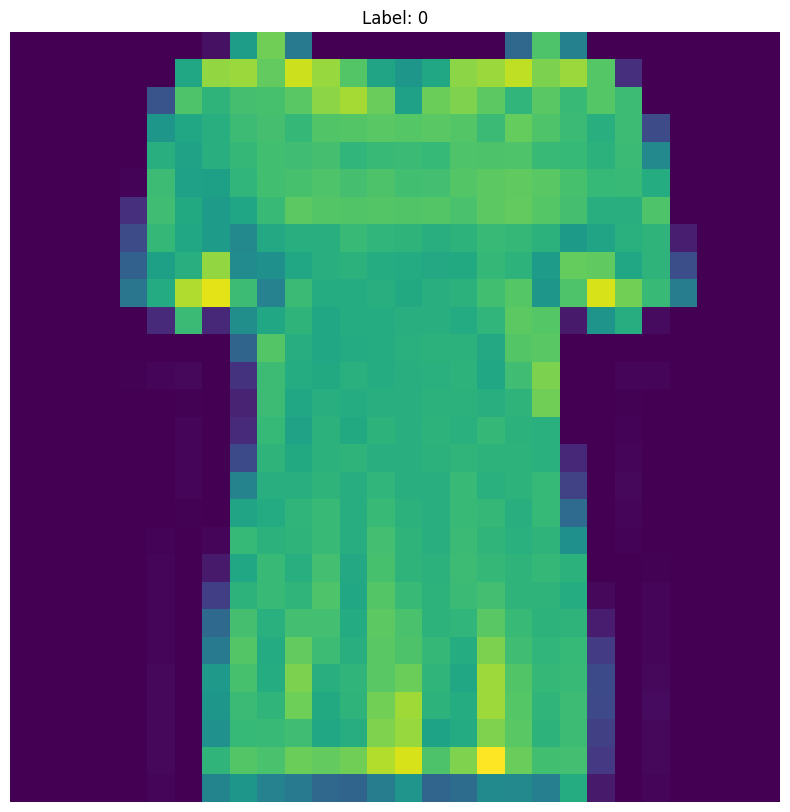

In [9]:
sample_img = fashion_mnist['train']['image'][10]
sample_label = fashion_mnist['train']['label'][10]
# an example of the image, label
# Display the image with a larger size
plt.figure(figsize=(10, 10))  # Adjust the figsize as needed
plt.imshow(sample_img)
plt.title('Label: ' + str(sample_label))
plt.axis('off')  # Turn off axis
plt.show()

## Pre-processing
According to the official fashion-mnist [source](https://github.com/zalandoresearch/fashion-mnist), the numerical labels in the dataset correspond to these categories. 

In [10]:
clothing_labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

In [11]:
# preprocess the test dataset labels based on domain knowledge
# for evaluation later
#train_labels = [clothing_labels[i] for i in fashion_trainy]
#test_labels = [clothing_labels[i] for i in fashion_testy]


In [12]:
# creating the train sets
fashion_trainx = [tensor(img).byte() for img in fashion_trainx]
# creating the test sets
fashion_testx = [tensor(img).byte() for img in fashion_testx]

In [13]:
# creating the dsets
train_dset = list(zip(fashion_trainx, fashion_trainx))
test_dset = list(zip(fashion_testx, fashion_trainy))

In [105]:
# Define a batch size
batch_size = 64

# Define the desired width and height for resizing
new_width, new_height = 8, 8

# Define the transforms to be applied to each image
item_tfms = [Resize(new_width, new_height)]

# creating a train, test dataloader
fashiontraindl = ImageDataLoaders.from_dsets(train_dset, batch_size=batch_size, after_item=item_tfms, after_batch=[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)])
fashiontestdl = ImageDataLoaders.from_dsets(test_dset, batch_size=batch_size, after_item=item_tfms, after_batch=[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)])

In [29]:
print(fashiontestdl.one_batch()[0].size())
print(fashiontestdl.one_batch()[1].size())

torch.Size([64, 28, 28])
torch.Size([64])


## Training an Object Detection Model: Attempt #1

We will training a custom clothing object detection model.

In [30]:
class CustomEncoder(nn.Module):
    def __init__(self):
        super(CustomEncoder, self).__init__()
        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 25088*2, kernel_size=3, stride=1, padding=1)
        # Add more layers as needed
        self.fc2 = nn.Linear(14, 256)
        self.fc3 = nn.Linear(256, 1024)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # Add more layers and operations to achieve the desired output size
        return x


In [31]:
encoder = CustomEncoder()

In [32]:
encoder

CustomEncoder(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 50176, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=14, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1024, bias=True)
)

In [33]:
class FashionModel(Module):
    def __init__(self, encoder, head):
        super(FashionModel, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x1):
        print("Input batch shape:", x1.size())

        # Pass input through encoder
        pretrained_ftrs1 = self.encoder(x1.float()) #important: float tensor
        print("Encoder output shape:", pretrained_ftrs1.size())

        # Pass encoder output through head
        custom_ftrs_2 = pretrained_ftrs1
        print("Head:")
        for layer in self.head:
            custom_ftrs_2 = layer(custom_ftrs_2)
            print(layer)
            print("  Output shape after head layer:", custom_ftrs_2.size())

        return custom_ftrs_2

In [34]:
from torch.nn import Sequential, AdaptiveAvgPool2d, AdaptiveMaxPool2d, Flatten, Dropout, Linear, ReLU,Softmax

In [35]:
head = nn.Sequential(
    AdaptiveConcatPool2d(1),
    Flatten(1),
    Dropout(p=0.25),
    Linear(2, 1024),
    Dropout(p=0.25),
    Linear(1024, 2048),
    ReLU(inplace=True),
    Dropout(p=0.5),
    Linear(2048, 9, bias=False)
)

model = FashionModel(encoder,head)

In [36]:
encoder

CustomEncoder(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 50176, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=14, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1024, bias=True)
)

In [37]:
def splitter(model):
    return [params(model.encoder), params(model.head)]
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [38]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [39]:
learn = Learner(fashiontraindl, model, loss_func=CrossEntropyLossFlat(), splitter=splitter, metrics=accuracy)
learn.freeze()

In [40]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=2, out_features=1024, bias=True)
  (4): Dropout(p=0.25, inplace=False)
  (5): Linear(in_features=1024, out_features=2048, bias=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=2048, out_features=9, bias=False)
)

In [41]:
learn.lr_find()

Input batch shape: torch.Size([64, 28, 28])
Encoder output shape: torch.Size([50176, 14, 1024])
Head:
AdaptiveConcatPool2d(
  (ap): AdaptiveAvgPool2d(output_size=1)
  (mp): AdaptiveMaxPool2d(output_size=1)
)
  Output shape after head layer: torch.Size([50176, 2, 1])
Flatten(start_dim=1, end_dim=-1)
  Output shape after head layer: torch.Size([50176, 2])
Dropout(p=0.25, inplace=False)
  Output shape after head layer: torch.Size([50176, 2])
Linear(in_features=2, out_features=1024, bias=True)
  Output shape after head layer: torch.Size([50176, 1024])
Dropout(p=0.25, inplace=False)
  Output shape after head layer: torch.Size([50176, 1024])
Linear(in_features=1024, out_features=2048, bias=True)
  Output shape after head layer: torch.Size([50176, 2048])
ReLU(inplace=True)
  Output shape after head layer: torch.Size([50176, 2048])
Dropout(p=0.5, inplace=False)
  Output shape after head layer: torch.Size([50176, 2048])
Linear(in_features=2048, out_features=9, bias=False)
  Output shape after h

IndexError: Target 47 is out of bounds.

## Training an Object Detection Model: Attempt #2
Using different data:

1. In attempt#1, I was directly dataloading from torch tensors into a fastai dataloader (constructing my own dsets).
2. In attempt #2, I am storing the data as a fastai datablock having a path to a content folder directory before input to the dataloader.

Using different models:

1. In attempt#1, I was using torch methods to build my own custom classifier that could utilize the fast AI dataloaders and learners to train the model and simplify model creation.
2. In attempt#2, I am fully using the fastAI library to load the data, build the model, and finetune in only a few lines.

I used the same fashion-mnist set but instead of using the datasets/huggingface implementation I used a different version which can be found here:

https://www.evanmarie.com/fashion-mnist-vs-fast-ai/

Credit to the author for the implementation.


In [44]:
with ZipFile('../../data/image_data/fashion_mnist_images.zip') as f:
   f.extractall()

In [42]:
path = Path("/content/fashion_mnist_images_training_validation")

In [45]:
image_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.5),
    get_y=parent_label,
    item_tfms=Resize(28))

In [46]:
fashiontraindl = image_datablock.dataloaders(path)

In [116]:
learner = vision_learner(fashiontraindl, resnet34, n_out=9, loss_func=loss_func, metrics=accuracy)

In [48]:
learner.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.052770,0.782087,0.725605,01:41


epoch,train_loss,valid_loss,accuracy,time
0,0.557229,0.444859,0.835370,01:45
1,0.433583,0.358177,0.867738,01:45
2,0.361758,0.312627,0.888533,01:44
3,0.285001,0.308525,0.888567,01:42
4,0.241960,0.299534,0.893639,01:42
5,0.174684,0.294189,0.902182,01:42
6,0.116947,0.318127,0.904360,01:43
7,0.072477,0.356336,0.906198,01:43
8,0.041783,0.384374,0.907083,01:58
9,0.028258,0.391937,0.907389,01:43
